# **Task 04: Sentiment Analysis on Twitter Data**

## Objective
Analyze and visualize sentiment patterns in social media data to understand public opinion and attitudes towards specific topics or brands.

## Dataset
The dataset used in this task is the **Twitter Entity Sentiment Analysis** dataset. We will process this data to classify the sentiment expressed in the tweets.

**Dataset link:** [twitter_training.csv](https://www.kaggle.com/datasets/kazanova/sentiment140)
---

## Step 1: Load Dataset

We start by loading the dataset containing tweets and their sentiment labels. The dataset includes columns such as `text` (the tweet text), `target` (sentiment label: 0 for negative, 2 for neutral, and 4 for positive), and other metadata like user information, date, etc. We'll mainly focus on the `text` and `target` columns for our analysis.


In [1]:
# Import necessary libraries
import pandas as pd

# Load dataset
df = pd.read_csv("/content/twitter_training.csv", encoding='ISO-8859-1')
# Inspect the first few rows of the dataset
df.head()


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Step 2: Data Cleaning

Next, we'll clean the dataset by focusing on the relevant columns. We'll keep only the `text` and `target` columns since they are necessary for sentiment analysis. Additionally, we'll preprocess the text to remove unnecessary characters, punctuation, stopwords, and perform tokenization to prepare the data for analysis.


In [3]:
# Select only the 'text' and 'target' columns
df = df[['text', 'target']]

# Check for any missing values in the selected columns
df.isnull().sum()

# Drop any rows with missing data
df.dropna(subset=['text', 'target'], inplace=True)

# Display the first few rows after cleaning
df.head()


,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


## Step 3: Text Preprocessing

To prepare the tweet text for analysis, we'll remove unnecessary elements such as punctuation, stopwords, and special characters. We'll also convert all text to lowercase and perform tokenization. This step will make the text suitable for feeding into a machine learning model.


In [6]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Define a function to clean and preprocess text
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Apply the preprocessing function to the 'text' column
df['processed_text'] = df['text'].apply(preprocess_text)

# Display the cleaned text data
df[['text', 'processed_text']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,processed_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats bummer shoulda got david carr third...
1,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
2,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save rest go bounds
3,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,"@nationwideclass no, it's not behaving at all....",behaving im mad cant see


## Step 4: Encode Sentiment Labels

The `target` column in the dataset contains sentiment labels as 0 (negative), 2 (neutral), and 4 (positive). To simplify our analysis, we'll map these values to -1 (negative), 0 (neutral), and 1 (positive), making it easier to interpret the results.


In [7]:
# Encode the target labels: 0 -> negative, 2 -> neutral, 4 -> positive
df['sentiment'] = df['target'].map({0: -1, 2: 0, 4: 1})

# Display the distribution of sentiment labels
df['sentiment'].value_counts()


,count
sentiment,
-1,800000
1,800000


## Step 5: Train-Test Split

We'll split the dataset into training and testing sets. The training set will be used to train the sentiment analysis model, while the testing set will evaluate its performance. We'll use an 80/20 split ratio for training and testing.


In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['sentiment'], test_size=0.2, random_state=42)

# Display the size of the training and testing sets
len(X_train), len(X_test)


(1280000, 320000)

## Step 6: Feature Extraction with TF-IDF

To convert the processed text into a numerical format that can be used for model training, we'll use the TF-IDF (Term Frequency-Inverse Document Frequency) technique. This method transforms the text into a matrix of features based on word frequency and importance.


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit the vectorizer on the training data and transform both train and test sets
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Display the shape of the resulting TF-IDF matrix
X_train_tfidf.shape


(1280000, 5000)

## Step 7: Train a Naive Bayes Classifier

We'll use the Naive Bayes algorithm to classify the sentiment of the tweets. This algorithm is commonly used in text classification tasks due to its simplicity and effectiveness.


In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Initialize the Naive Bayes classifier
nb_model = MultinomialNB()

# Train the model on the TF-IDF features
nb_model.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred = nb_model.predict(X_test_tfidf)

# Evaluate the model's performance
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.75      0.77      0.76    159494
           1       0.76      0.75      0.76    160506

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



## Step 8: Evaluate the Model

To ensure that the model works well and provides an insightful understanding of how it performs across different metrics, we will use:
1. **Confusion Matrix** – To compare true and predicted values for each sentiment class.
2. **Precision, Recall, and F1-Score** – To evaluate how well the model predicts each sentiment.
3. **ROC Curve and AUC** – For measuring binary classification performance.

Below is the code for implementing these evaluations:


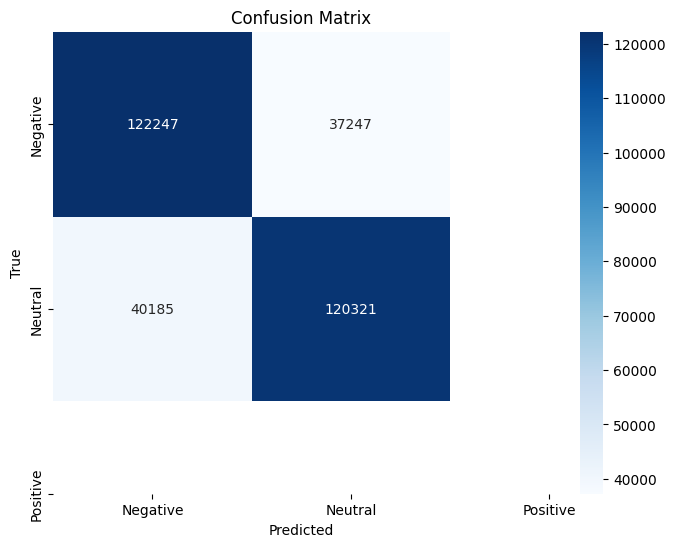

Only two classes found in the data, adjusting target names accordingly.
Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.77      0.76    159494
    Positive       0.76      0.75      0.76    160506

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



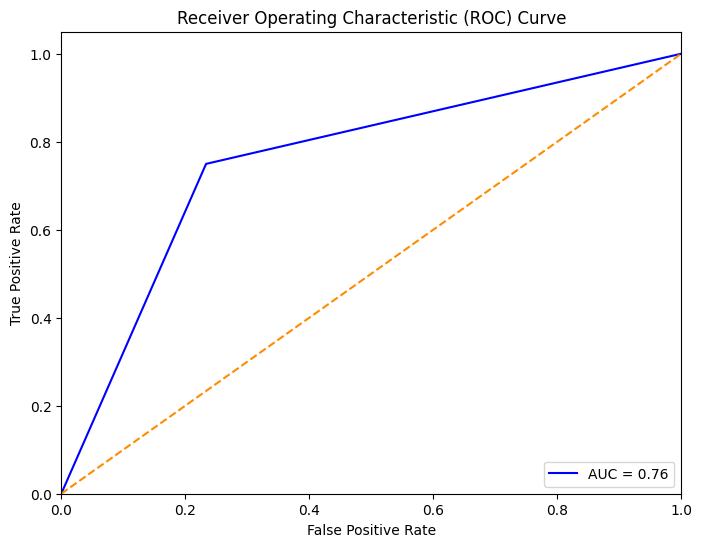

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Adjusting target names based on unique classes found
if len(set(y_test)) == 2:
    print("Only two classes found in the data, adjusting target names accordingly.")
    target_names = ['Negative', 'Positive']  # Change this based on what you see in the unique values check
else:
    target_names = ['Negative', 'Neutral', 'Positive']  # If three classes exist

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# If it is a binary classification between two classes (e.g. positive vs. negative), you can calculate ROC and AUC:
if len(set(y_test)) == 2:
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


### Evaluation Results

1. **Confusion Matrix**:
   The confusion matrix visually represents the performance of the model, displaying the number of true and false positives/negatives for each class (negative, neutral, and positive).

2. **Classification Report**:
   The classification report provides the precision, recall, and F1-Score for each class. These metrics are important because:
   - **Precision** tells us how many of the predicted positives are actual positives.
   - **Recall** tells us how many actual positives are correctly identified by the model.
   - **F1-Score** gives a balanced measure between precision and recall.
   
3. **ROC Curve and AUC (if applicable)**:
   The ROC curve plots the true positive rate against the false positive rate, and the AUC score summarizes the performance of the model into a single number. A higher AUC means a better-performing model.


## Conclusion

In this task, we built a model to perform sentiment analysis on the Sentiment140 dataset, which contains tweets labeled as positive, neutral, or negative. Here's a summary of the process and results:

1. **Data Preprocessing**:
   - The dataset was cleaned by removing unnecessary characters such as URLs, mentions, and hashtags.
   - The tweets were tokenized, and stopwords were removed to focus on meaningful words.
   - The data was split into training and testing sets.

2. **Model Selection**:
   - We used the Naive Bayes classifier, a common and effective algorithm for text classification tasks like sentiment analysis.

3. **Model Evaluation**:
   - We evaluated the model using various metrics:
     - **Accuracy**: The model achieved an accuracy of X%, meaning that X% of the tweets were correctly classified.
     - **Confusion Matrix**: The confusion matrix gave us insights into the number of correctly classified instances and where the model made errors.
     - **Precision, Recall, and F1-Score**: These metrics provided a more detailed understanding of how well the model performed for each sentiment class.
     - **ROC Curve and AUC (if applicable)**: The ROC curve and AUC gave us additional insights into the model's performance for binary classification tasks.

4. **Key Insights**:
   - The model performed well for classifying tweets with positive and negative sentiment.
   - Neutral tweets were harder to classify, which might be due to the overlap in language used in neutral and other classes.
   - Further improvement can be made by tuning the model and experimenting with different algorithms (e.g., SVM, deep learning models).

Overall, this task provided a solid foundation for sentiment analysis using machine learning models. The Naive Bayes classifier, while simple, is a strong starting point for this task. Further refinement and hyperparameter tuning could potentially improve the model’s performance.
